# X-ray Classification #
### 0. import libraries ###

In [3]:

import jupyter
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.callbacks import EarlyStopping
from keras import layers

import matplotlib.pyplot as plt
import numpy

### gain insight of data ###
- 3 classes: Covid; Normal; Viral Pneumonia (multi-class classification)
- data already split into test and train
- gray scale images

### 1. preprocessing data ###
- use <ImageGenerator()> object
- rescale images with pixel normalization

In [10]:
#Creates an ImageDataGenerator:
data_generator = ImageDataGenerator(rescale = 1.0/255)
data_generator = ImageDataGenerator(rescale = 1.0/255, zoom_range = 0.2,rotation_range=15, width_shift_range = 0.05, height_shift_range = 0.05)

#Prints its attributes:
print(data_generator.__dict__)

#Now, we can use the ImageDataGenerator object that we just created to load and batch our data, using its .flow_from_directory() method.
TRAIN_DIRECTORY = "Covid19-dataset/train"
TEST_DIRECTORY = "Covid19-dataset/test"
CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)
BATCH_SIZE = 32

#Creates a DirectoryIterator object using the above parameters:

training_iterator = data_generator.flow_from_directory(TRAIN_DIRECTORY, class_mode=CLASS_MODE, color_mode=COLOR_MODE, target_size=TARGET_SIZE, batch_size=BATCH_SIZE)
sample_batch_input, sample_batch_labels = training_iterator.next()

validation_iterator = data_generator.flow_from_directory(TEST_DIRECTORY, class_mode=CLASS_MODE, color_mode=COLOR_MODE, target_size=TARGET_SIZE, batch_size=BATCH_SIZE)
sample_batch_input, sample_batch_labels = validation_iterator.next()
print(sample_batch_input.shape,sample_batch_labels.shape)

{'featurewise_center': False, 'samplewise_center': False, 'featurewise_std_normalization': False, 'samplewise_std_normalization': False, 'zca_whitening': False, 'zca_epsilon': 1e-06, 'rotation_range': 15, 'width_shift_range': 0.05, 'height_shift_range': 0.05, 'shear_range': 0.0, 'zoom_range': [0.8, 1.2], 'channel_shift_range': 0.0, 'fill_mode': 'nearest', 'cval': 0.0, 'horizontal_flip': False, 'vertical_flip': False, 'rescale': 0.00392156862745098, 'preprocessing_function': None, 'dtype': 'float32', 'interpolation_order': 1, 'data_format': 'channels_last', 'channel_axis': 3, 'row_axis': 1, 'col_axis': 2, '_validation_split': 0.0, 'mean': None, 'std': None, 'zca_whitening_matrix': None, 'brightness_range': None}
Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
(32, 256, 256, 1) (32, 3)


### 2. Design Model ###


In [49]:
tf.keras.backend.clear_session()
#build model
print("\nBuilding model...")
model = Sequential()
model.add(keras.Input(shape=(256, 256, 1)))
model.add(layers.Conv2D(3, 8, strides=2, padding = 'same', activation="relu")) 
model.add(layers.MaxPooling2D(
    pool_size=(2, 2), strides=(2,2)))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(3, 5, strides=2, padding = 'same', activation="relu")) 
model.add(layers.MaxPooling2D(
    pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.2))


model.add(layers.Flatten())
#model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(3, activation="softmax"))
# compile model
print("\nCompiling model...")
#Compile the model with an Adam optimizer, Categorical Cross Entropy Loss, and Accuracy and AUC metrics:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.AUC()]
)
model.summary()

# early stopping implementation
es = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=10)


print("\nTraining model...")

#Use model.fit(...) to train and validate our model with 20 ephochs and early stopping

history =model.fit(
        training_iterator,
        steps_per_epoch=training_iterator.samples/BATCH_SIZE, 
        epochs=20,
        validation_data=validation_iterator,
        validation_steps=validation_iterator.samples/BATCH_SIZE,
        callbacks = [es]
        )



Building model...

Compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 3)       195       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 3)         228       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 3)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropo

### Plot training progress ###

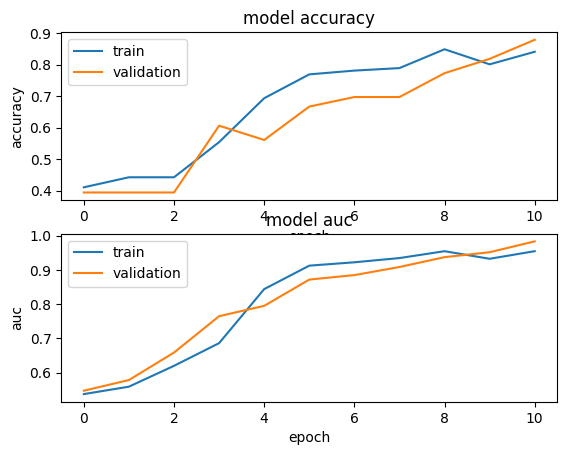

In [50]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

### Confusion matrix and report ###
get scores to indicate the model performance

In [1]:
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   
 
cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

NameError: name 'numpy' is not defined